# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [145]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Pre-processing

Let's take an initial look at the datasets to have an understanding of their structure and decide what to do next for pre-processing.

In [146]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [147]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [148]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


## 1. Data in various columns are saved under dictionary/list types and the id(s) are strings. We need to convert those data types into intergers, boolean so we can use them for analytics tasks. 

### Handling the list type

'channels' column in 'portfolio' is under list type. We will convert it to dummies columns do display if any channel was used for each offer.

In [149]:
portfolio['is_email']=portfolio.apply(lambda x: 'email' in x['channels'], axis=1)
portfolio['is_mobile']=portfolio.apply(lambda x: 'mobile' in x['channels'], axis=1)
portfolio['is_social']=portfolio.apply(lambda x: 'social' in x['channels'], axis=1)
portfolio['is_web']=portfolio.apply(lambda x: 'web' in x['channels'], axis=1)

### Handling the string ids

In [150]:
#Encode function to convert ids from string to number
def id_mapper(df,col='id'):
    '''
    INPUT:
    df - (pandas dataframe) the dataframe that you want to perform conversion
    col - (str) df column that you want to perform conversion 
    
    OUTPUT:
    id_encoded - (series) a series of encoded data
    
    '''
    coded_dict = dict()
    seq = 1
    id_encoded = []
    
    for val in df[col]:
        if val not in coded_dict:
            coded_dict[val] = seq
            seq+=1
        
        id_encoded.append(coded_dict[val])
    return id_encoded

In [151]:
#Encode offer and profile id(s)
portfolio['offer_id'] = id_mapper(portfolio)
profile['person_id'] = id_mapper(profile)

In [152]:
#Mapping profile and transcript by person
transcript = pd.merge(transcript,profile[['id','person_id']],left_on=['person'],right_on=['id'],how='left')
#Remove the duplicated 'id' column
transcript = transcript.drop(['id'],axis=1)
transcript.head()

,event,person,time,value,person_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},4
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},5
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},6
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},7
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},8


### Handling the dictionaries

For the 'transcript' dataset, there are various event type and the 'value' column structure will change accordingly. We need to split this dataset into event type datasets and decompose the 'value' column. After that, we will map the offer related datasets with 'portfolio' dataset to get the offer_id. 

In [153]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [154]:
# Split the dataset
offer_received_event = transcript[transcript['event'] == 'offer received']
offer_viewed_event = transcript[transcript['event'] == 'offer viewed']
offer_completed_event = transcript[transcript['event'] == 'offer completed']
transaction_event = transcript[transcript['event'] == 'transaction']

In [155]:
# Take a look at the 'offer_received_event' data to see the structure
offer_received_event.head()

,event,person,time,value,person_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},4
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},5
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},6
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},7
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},8


For offer_received_event, we have to get the offer if from 'value' column and then map it with the 'portfolio' dataset to get encoded offer_id.

In [156]:
# Get offer id out of 'value' column
offer_received_event['offer_id_org']=offer_received_event.apply(lambda x: x['value']['offer id'], axis=1)
# Map with 'portfolio'
offer_received_event = pd.merge(offer_received_event,portfolio[['id','offer_id']],left_on=['offer_id_org'],right_on=['id'],how='left')
# Remove unnecessary columns
offer_received_event = offer_received_event.drop(['event','person','offer_id_org','id','value'],axis=1)
offer_received_event.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,time,person_id,offer_id
0,0,4,4
1,0,5,5
2,0,6,10
3,0,7,7
4,0,8,2


In [157]:
# Take a look at 'offer_viewed_event' data to see the structure.
offer_viewed_event.head()

,event,person,time,value,person_id
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},9
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},32
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},36
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},42
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},49


Similar with 'offer_received_event', we need to get the offer id from 'value' column to map it with 'portfolio' data and then remove unneccessary columns.

In [158]:
# Get offer id out of 'value' column
offer_viewed_event['offer_id_org']=offer_viewed_event.apply(lambda x: x['value']['offer id'], axis=1)
# Map with 'portfolio'
offer_viewed_event = pd.merge(offer_viewed_event,portfolio[['id','offer_id']],left_on=['offer_id_org'],right_on=['id'],how='left')
# Remove unnecessary columns
offer_viewed_event = offer_viewed_event.drop(['event','person','offer_id_org','id','value'],axis=1)
offer_viewed_event.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,time,person_id,offer_id
0,0,9,9
1,0,32,8
2,0,36,2
3,0,42,1
4,0,49,8


In [159]:
# Take a look at 'offer_completed_event' data to see the structure.
pd.set_option('display.max_colwidth', 100)  
offer_completed_event.head()
#pd.reset_option('display.max_colwidth')

,event,person,time,value,person_id
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,"{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}",56
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,"{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}",152
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,"{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}",175
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,"{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd', 'reward': 10}",300
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,"{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0', 'reward': 10}",317


For this dataframe, we need to get offer id and reward from 'value' column and then map with 'portfolio' to get the encoded offer id.

In [160]:
# Get offer id and reward out of 'value' column
offer_completed_event['offer_id_org']=offer_completed_event.apply(lambda x: x['value']['offer_id'], axis=1)
offer_completed_event['reward']=offer_completed_event.apply(lambda x: x['value']['reward'], axis=1)
# Map with 'portfolio'
offer_completed_event = pd.merge(offer_completed_event,portfolio[['id','offer_id']],left_on=['offer_id_org'],right_on=['id'],how='left')
# Remove unnecessary columns
offer_completed_event = offer_completed_event.drop(['event','person','offer_id_org','id','value'],axis=1)
offer_completed_event.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,time,person_id,reward,offer_id
0,0,56,2,10
1,0,152,2,7
2,0,175,5,4
3,0,300,10,1
4,0,317,10,2


In [161]:
# Take a look at 'transaction_event' dataframe to see the structure.
transaction_event.head()

,event,person,time,value,person_id
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001},42
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56},56
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23},64
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51},135
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97},152


For Transaction_event data, we have to get the amount from 'value' column.

In [162]:
# Get amount from 'value' column
transaction_event['amount']=transaction_event.apply(lambda x: x['value']['amount'], axis=1)
# Remove unneccessary columns
transaction_event = transaction_event.drop(['event','person','value'],axis=1)
transaction_event.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,time,person_id,amount
12654,0,42,0.83
12657,0,56,34.56
12659,0,64,13.23
12670,0,135,19.51
12671,0,152,18.97


In [163]:
#Remove the unused columns from other dataframes
portfolio = portfolio.drop(['channels','id'],axis=1)
profile = profile.drop(['id'],axis=1)

In [164]:
portfolio.head()

,difficulty,duration,offer_type,reward,is_email,is_mobile,is_social,is_web,offer_id
0,10,7,bogo,10,True,True,True,False,1
1,10,5,bogo,10,True,True,True,True,2
2,0,4,informational,0,True,True,False,True,3
3,5,7,bogo,5,True,True,False,True,4
4,20,10,discount,5,True,False,False,True,5


In [165]:
profile.head()

,age,became_member_on,gender,income,person_id
0,118,20170212,None,NaN,1
1,55,20170715,F,112000.0,2
2,118,20180712,None,NaN,3
3,75,20170509,F,100000.0,4
4,118,20170804,None,NaN,5


## 2. Handling the date
We have to convert the date column became_member_on to in dicate the time the customer has been registered with the company. The reason is that when a customer stay longer, they will have more time and likely more transactions with the company. To see evaluate customer's peformance, we need to see their average spending per day, instead of total spending.

In [166]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'],format='%Y%m%d')
profile['current_date'] = pd.to_datetime('today')
profile['member_period'] = (profile['current_date']-profile['became_member_on']).dt.days
profile.head()

,age,became_member_on,gender,income,person_id,current_date,member_period
0,118,2017-02-12,None,NaN,1,2022-01-09 08:30:50.923708,1792
1,55,2017-07-15,F,112000.0,2,2022-01-09 08:30:50.923708,1639
2,118,2018-07-12,None,NaN,3,2022-01-09 08:30:50.923708,1277
3,75,2017-05-09,F,100000.0,4,2022-01-09 08:30:50.923708,1706
4,118,2017-08-04,None,NaN,5,2022-01-09 08:30:50.923708,1619


## 3.Handling categorical group

'gender' is a categorical group. In order to use it for further calculation, we will convert it into numeric values.

In [167]:
profile['gender_id'] = id_mapper(profile,'gender')
profile.head()

,age,became_member_on,gender,income,person_id,current_date,member_period,gender_id
0,118,2017-02-12,None,NaN,1,2022-01-09 08:30:50.923708,1792,1
1,55,2017-07-15,F,112000.0,2,2022-01-09 08:30:50.923708,1639,2
2,118,2018-07-12,None,NaN,3,2022-01-09 08:30:50.923708,1277,1
3,75,2017-05-09,F,100000.0,4,2022-01-09 08:30:50.923708,1706,2
4,118,2017-08-04,None,NaN,5,2022-01-09 08:30:50.923708,1619,1


## 4.Handling N/A values

In [168]:
# Check dataframes for N/A values. Portfolio and Transcripts should not contain N/A as they were 
# exported from Starbucks' system. The only dataset that may contain N/A is profile
profile.isnull().sum(axis = 0)

age                    0
became_member_on       0
gender              2175
income              2175
person_id              0
current_date           0
member_period          0
gender_id              0
dtype: int64

In [169]:
profile.shape

(17000, 8)

People who do not reveal age will be encoded with value 118 in age column. We will check the number of missing value in 'age'.

In [170]:
profile[profile['age'] == 118].shape[0]

2175

There are 17000 people in 'profile' dataset and only 2175 of them contain N/A values. 
The number of N/A value in age, gender and income columns are equal. We will check if those came from the same set of people.

In [171]:
null_df = profile['gender'].isnull() & profile['income'].isnull() & (profile['age'] == 118)
null_df.sum()

2175

So all people that have N/A in 'gender' have N/A in 'income' and 'age'. Those can be classified as a specific group who don't want to reveal their personal information. We can call them as 'high_secure' group and analyze their behavior separately. 
For now, we will split the 'profile' dataset into 'profile_low_secure' and 'profile_high_secure'

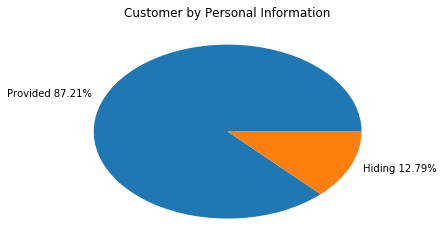

In [202]:
# We can see here the portion of the 2 groups
security_portion = profile.groupby(profile['gender'].isnull()).size().values*100/profile['person_id'].count()
plt.pie(security_portion,
        labels=[f'Provided {round(security_portion[0],2)}%',f'Hiding {round(security_portion[1],2)}%'])
plt.title("Customer by Personal Information")
plt.show()

In [173]:
#Create the dummy variable to indicate whether customer provide personal information or not
profile['provided_info']=profile['gender'].isnull()
profile.head()

,age,became_member_on,gender,income,person_id,current_date,member_period,gender_id,provided_info
0,118,2017-02-12,None,NaN,1,2022-01-09 08:30:50.923708,1792,1,True
1,55,2017-07-15,F,112000.0,2,2022-01-09 08:30:50.923708,1639,2,False
2,118,2018-07-12,None,NaN,3,2022-01-09 08:30:50.923708,1277,1,True
3,75,2017-05-09,F,100000.0,4,2022-01-09 08:30:50.923708,1706,2,False
4,118,2017-08-04,None,NaN,5,2022-01-09 08:30:50.923708,1619,1,True


In [174]:
profile_low_secure = profile[profile['gender'].isnull() == False]
profile_high_secure = profile[profile['gender'].isnull()]
profile_high_secure=profile_high_secure.drop(['gender','income'],axis=1)

In [175]:
profile_high_secure.head()

,age,became_member_on,person_id,current_date,member_period,gender_id,provided_info
0,118,2017-02-12,1,2022-01-09 08:30:50.923708,1792,1,True
2,118,2018-07-12,3,2022-01-09 08:30:50.923708,1277,1,True
4,118,2017-08-04,5,2022-01-09 08:30:50.923708,1619,1,True
6,118,2017-09-25,7,2022-01-09 08:30:50.923708,1567,1,True
7,118,2017-10-02,8,2022-01-09 08:30:50.923708,1560,1,True


In [176]:
profile_low_secure.head()

,age,became_member_on,gender,income,person_id,current_date,member_period,gender_id,provided_info
1,55,2017-07-15,F,112000.0,2,2022-01-09 08:30:50.923708,1639,2,False
3,75,2017-05-09,F,100000.0,4,2022-01-09 08:30:50.923708,1706,2,False
5,68,2018-04-26,M,70000.0,6,2022-01-09 08:30:50.923708,1354,3,False
8,65,2018-02-09,M,53000.0,9,2022-01-09 08:30:50.923708,1430,3,False
12,58,2017-11-11,M,51000.0,13,2022-01-09 08:30:50.923708,1520,3,False


# Business Problems

### Now that we've had a first look at the cleaned data, we can start to think about the business issues and the questions that we will be able to find answers from the dataset.

### 1. Understand the high security group

There are a portion of customers that have high sense of security and do not want to reveal personal information (gender, income, age). We want to know if there's any particular behavior from this group. This group accounts for 12,79% of the total customers so understand their behavior may provide more insights to sales and marketing strategies.<br>
To compare the differencies between 2 groups and define statistical significances, T-test is a reliable method and we will have it supported by descriptive statistics methodology.<br>
Finally we will run a regression model on the security feature and see how well it can help us with predicting customer puschase.

The first metric we want to focus on is the revenue - transaction amount.<br>
To get the average revenue of the high security group, we will have to pivot the transaction_event data by person_id to get the volume of each person and then map to the profile_high_secure dataframe.

In [177]:
# Get the volume by customer data
volume_df = transaction_event.groupby('person_id').agg({'amount':['sum', 'count']})
volume_df.columns = volume_df.columns.droplevel(level = 0)
#volume_df = volume_df.reset_index()
volume_df.head()

,sum,count
person_id,,
1,20.40,9
2,77.01,3
3,14.30,6
4,159.27,7
5,4.65,3


In [178]:
# Map the volume_df to profile and get the average volume
profile_volume = profile.join(volume_df, on='person_id')
# N/A volume indicate that there's no transaction with a customer so we can replace them with 0
profile_volume = profile_volume.fillna(0)
# Get the volume per day
profile_volume['daily_sum']=profile_volume['sum']/profile_volume['member_period']
profile_volume['daily_count']=profile_volume['count']/profile_volume['member_period']
profile_volume.head()

,age,became_member_on,gender,income,person_id,current_date,member_period,gender_id,provided_info,sum,count,daily_sum,daily_count
0,118,2017-02-12,0,0.0,1,2022-01-09 08:30:50.923708,1792,1,True,20.40,9.0,0.011384,0.005022
1,55,2017-07-15,F,112000.0,2,2022-01-09 08:30:50.923708,1639,2,False,77.01,3.0,0.046986,0.001830
2,118,2018-07-12,0,0.0,3,2022-01-09 08:30:50.923708,1277,1,True,14.30,6.0,0.011198,0.004699
3,75,2017-05-09,F,100000.0,4,2022-01-09 08:30:50.923708,1706,2,False,159.27,7.0,0.093359,0.004103
4,118,2017-08-04,0,0.0,5,2022-01-09 08:30:50.923708,1619,1,True,4.65,3.0,0.002872,0.001853


The second metrics will be offer responsiveness to evaluate the performance of promotional offers on customers.

In [179]:
# Get the offer received by customer data
offer_received_df = offer_received_event[['person_id','offer_id']].groupby('person_id').count()
offer_received_df = offer_received_df.reset_index()
offer_received_df.rename(columns={'offer_id': 'offer_received'}, inplace=True)
# Get the offer viewed by customer data
offer_viewed_df = offer_viewed_event[['person_id','offer_id']].groupby('person_id').count()
offer_viewed_df = offer_viewed_df.reset_index()
offer_viewed_df.rename(columns={'offer_id': 'offer_viewed'}, inplace=True)
# Get the offer completed by customer data
offer_completed_df = offer_completed_event[['person_id','offer_id']].groupby('person_id').count()
offer_completed_df = offer_completed_df.reset_index()
offer_completed_df.rename(columns={'offer_id': 'offer_completed'}, inplace=True)

In [180]:
# Map the offer counts into profile data and fill the N/A values with 0
profile_volume = pd.merge(profile_volume,offer_received_df,on='person_id',how='left')
profile_volume = pd.merge(profile_volume,offer_viewed_df,on='person_id',how='left')
profile_volume = pd.merge(profile_volume,offer_completed_df,on='person_id',how='left')
profile_volume = profile_volume.fillna(0)
profile_volume.head()

,age,became_member_on,gender,income,person_id,current_date,member_period,gender_id,provided_info,sum,count,daily_sum,daily_count,offer_received,offer_viewed,offer_completed
0,118,2017-02-12,0,0.0,1,2022-01-09 08:30:50.923708,1792,1,True,20.40,9.0,0.011384,0.005022,5.0,5.0,2.0
1,55,2017-07-15,F,112000.0,2,2022-01-09 08:30:50.923708,1639,2,False,77.01,3.0,0.046986,0.001830,2.0,0.0,1.0
2,118,2018-07-12,0,0.0,3,2022-01-09 08:30:50.923708,1277,1,True,14.30,6.0,0.011198,0.004699,2.0,2.0,0.0
3,75,2017-05-09,F,100000.0,4,2022-01-09 08:30:50.923708,1706,2,False,159.27,7.0,0.093359,0.004103,4.0,4.0,3.0
4,118,2017-08-04,0,0.0,5,2022-01-09 08:30:50.923708,1619,1,True,4.65,3.0,0.002872,0.001853,5.0,3.0,0.0


In [181]:
# Create the Viewed over Received and Completed over Received rates
profile_volume['view_rate']=profile_volume['offer_viewed']/profile_volume['offer_received']
profile_volume['complete_rate']=profile_volume['offer_completed']/profile_volume['offer_received']

In [182]:
# Check for N/A values
profile_volume['view_rate'].isnull().sum(axis = 0)

6

In [183]:
# Because the number of N/A in profile is very small, the rate will be calculated as 0 for N/A values.
profile_volume[['view_rate','complete_rate']]=profile_volume[['view_rate','complete_rate']].fillna(0)

In [184]:
profile_volume[['daily_sum','daily_count','offer_received','view_rate','complete_rate','provided_info']].corr()

,daily_sum,daily_count,offer_received,view_rate,complete_rate,provided_info
daily_sum,1.000000,0.361450,0.078747,0.139294,0.543509,-0.257626
daily_count,0.361450,1.000000,0.164239,0.122065,0.371981,-0.092747
offer_received,0.078747,0.164239,1.000000,-0.058852,0.005250,0.002787
view_rate,0.139294,0.122065,-0.058852,1.000000,0.192545,0.075662
complete_rate,0.543509,0.371981,0.005250,0.192545,1.000000,-0.365972
provided_info,-0.257626,-0.092747,0.002787,0.075662,-0.365972,1.000000


In [185]:
# Split the profile data set into 2 subsets for easier comparison
profile_info_provided = profile_volume[profile_volume['provided_info']==True]
profile_info_not_provided = profile_volume[profile_volume['provided_info']==False]

Get the correlation coefficient for 2 subsets

In [186]:
profile_info_provided[['daily_sum','daily_count','offer_received','view_rate','complete_rate']].corr()

,daily_sum,daily_count,offer_received,view_rate,complete_rate
daily_sum,1.000000,0.568565,0.127435,0.007272,0.528797
daily_count,0.568565,1.000000,0.165152,0.067363,0.416943
offer_received,0.127435,0.165152,1.000000,-0.041056,0.014035
view_rate,0.007272,0.067363,-0.041056,1.000000,-0.017528
complete_rate,0.528797,0.416943,0.014035,-0.017528,1.000000


In [187]:
profile_info_not_provided[['daily_sum','daily_count','offer_received','view_rate','complete_rate']].corr()

,daily_sum,daily_count,offer_received,view_rate,complete_rate
daily_sum,1.000000,0.361240,0.085613,0.175617,0.505106
daily_count,0.361240,1.000000,0.165327,0.138024,0.364277
offer_received,0.085613,0.165327,1.000000,-0.061819,0.006243
view_rate,0.175617,0.138024,-0.061819,1.000000,0.259562
complete_rate,0.505106,0.364277,0.006243,0.259562,1.000000


Get the statistics for 2 subsets

In [188]:
profile_info_provided[['daily_sum','daily_count','offer_received','view_rate','complete_rate']].describe()

,daily_sum,daily_count,offer_received,view_rate,complete_rate
count,2175.000000,2175.000000,2175.000000,2175.000000,2175.000000
mean,0.010479,0.003897,4.494713,0.806766,0.115487
std,0.010519,0.002427,1.086356,0.226346,0.181112
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.004275,0.002176,4.000000,0.666667,0.000000
50%,0.008361,0.003489,5.000000,0.833333,0.000000
75%,0.013272,0.005294,5.000000,1.000000,0.200000
max,0.108554,0.015488,6.000000,1.000000,1.000000


In [189]:
profile_info_not_provided[['daily_sum','daily_count','offer_received','view_rate','complete_rate']].describe()

,daily_sum,daily_count,offer_received,view_rate,complete_rate
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000
mean,0.065245,0.004633,4.485734,0.753270,0.487377
std,0.073362,0.002667,1.074694,0.236818,0.331082
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.017886,0.002725,4.000000,0.600000,0.200000
50%,0.049822,0.004195,5.000000,0.800000,0.500000
75%,0.088447,0.006151,5.000000,1.000000,0.750000
max,1.050508,0.021843,6.000000,1.000000,1.000000


Text(0,0.5,'Density')

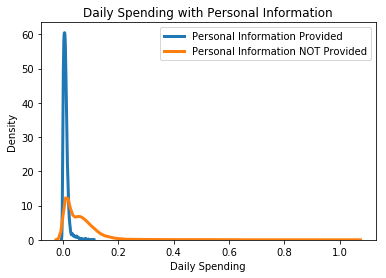

In [190]:
# Plot the daily spending distribution to see the difference
sns.distplot(profile_info_provided['daily_sum'], hist = False, kde = True,
             kde_kws = {'linewidth': 3},
             label = 'Personal Information Provided')
sns.distplot(profile_info_not_provided['daily_sum'], hist = False, kde = True,
             kde_kws = {'linewidth': 3},
             label = 'Personal Information NOT Provided')
plt.legend()
plt.title('Daily Spending with Personal Information')
plt.xlabel('Daily Spending')
plt.ylabel('Density')

Text(0,0.5,'Density')

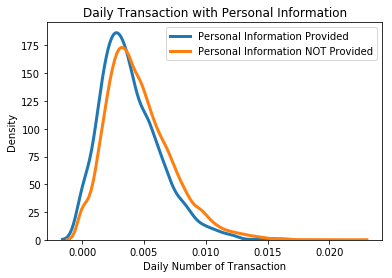

In [191]:
# Plot the daily number of transaction distribution to see the difference
sns.distplot(profile_info_provided['daily_count'], hist = False, kde = True,
             kde_kws = {'linewidth': 3},
             label = 'Personal Information Provided')
sns.distplot(profile_info_not_provided['daily_count'], hist = False, kde = True,
             kde_kws = {'linewidth': 3},
             label = 'Personal Information NOT Provided')
plt.legend()
plt.title('Daily Transaction with Personal Information')
plt.xlabel('Daily Number of Transaction')
plt.ylabel('Density')

In [192]:
from scipy.stats import ttest_ind
# Perform T-test on volume
ttest_sum=ttest_ind(profile_info_provided['daily_sum'], profile_info_not_provided['daily_sum'])
ttest_count=ttest_ind(profile_info_provided['daily_count'], profile_info_not_provided['daily_count'])
print(f'T-test result on daily spending amount: {ttest_sum}')
print(f'T-test result on daily spending number: {ttest_count}')

T-test result on daily spending amount: Ttest_indResult(statistic=-34.761804418290296, pvalue=7.682101195656904e-256)
T-test result on daily spending number: Ttest_indResult(statistic=-12.144414732516539, pvalue=8.4786493017306642e-34)


Text(0,0.5,'Density')

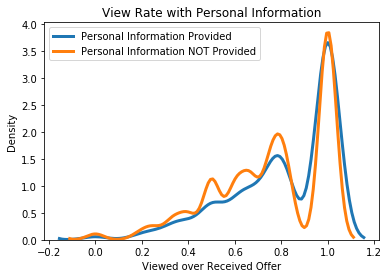

In [193]:
# Plot the view rate
sns.distplot(profile_info_provided['view_rate'], hist = False, kde = True,
             kde_kws = {'linewidth': 3},
             label = 'Personal Information Provided')
sns.distplot(profile_info_not_provided['view_rate'], hist = False, kde = True,
             kde_kws = {'linewidth': 3},
             label = 'Personal Information NOT Provided')
plt.legend()
plt.title('View Rate with Personal Information')
plt.xlabel('Viewed over Received Offer')
plt.ylabel('Density')

Text(0,0.5,'Density')

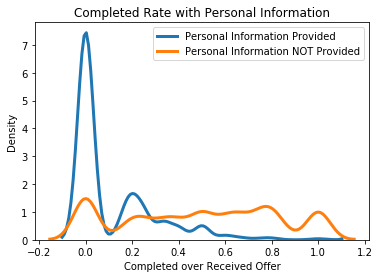

In [194]:
# Plot the complete rate
sns.distplot(profile_info_provided['complete_rate'], hist = False, kde = True,
             kde_kws = {'linewidth': 3},
             label = 'Personal Information Provided')
sns.distplot(profile_info_not_provided['complete_rate'], hist = False, kde = True,
             kde_kws = {'linewidth': 3},
             label = 'Personal Information NOT Provided')
plt.legend()
plt.title('Completed Rate with Personal Information')
plt.xlabel('Completed over Received Offer')
plt.ylabel('Density')

In [195]:
# Perform T-test on offer responsiveness
ttest_view=ttest_ind(profile_info_provided['view_rate'], profile_info_not_provided['view_rate'])
ttest_com=ttest_ind(profile_info_provided['complete_rate'], profile_info_not_provided['complete_rate'])
print(f'T-test result on viewed over received offer: {ttest_view}')
print(f'T-test result on completed over received offer: {ttest_com}')

T-test result on viewed over received offer: Ttest_indResult(statistic=9.8928866265652839, pvalue=5.1576013423780042e-23)
T-test result on completed over received offer: Ttest_indResult(statistic=-51.271049956216942, pvalue=0.0)


The T-test result as well as statistics & correlation coefficient indicated that there was a difference in performance between the group of people who provided information and who did not. Because of that, 'provided_info' can be considered an important feature which has impact on both volume and offer responsiveness.

Now we will try to use 'provided_info' as well as other features to predict the customer volume. Because we can see in the analysis above that the difference in daily number of transaction between 2 groups were not high, we will focus the futher analysis on daily spending amount only.

In [207]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from scipy import stats


X = profile_volume[['provided_info', 'offer_received', 'complete_rate']]
y = profile_volume['daily_sum']

# Perform linear regression and get the R2 score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=420)

reg = LinearRegression()
reg = reg.fit(X_train, y_train)
R2_train = reg.score(X_train, y_train)
R2_test = reg.score(X_test, y_test)

print(f'R2 score for train set is: {R2_train}')
print(f'R2 score for test set is: {R2_test}')

R2 score for train set is: 0.3034807290572925
R2 score for test set is: 0.30901392017634677


Try 1.


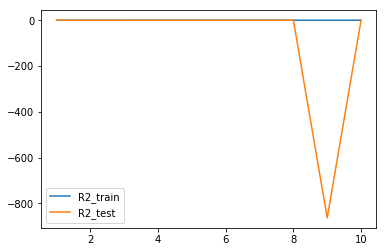

Try 2.


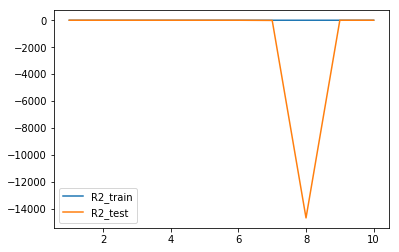

Try 3.


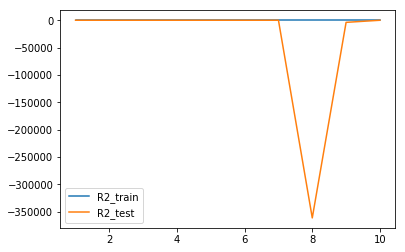

Try 4.


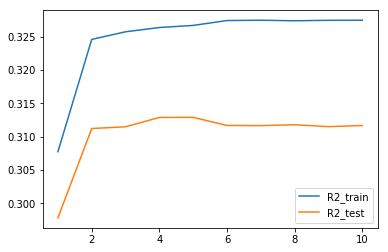

Try 5.


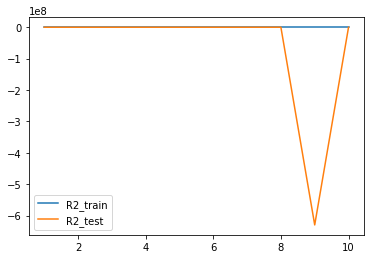

Try 6.


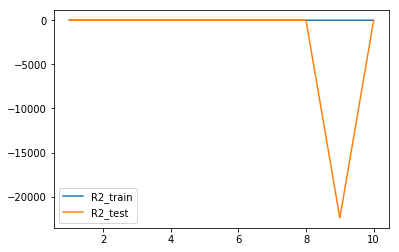

Try 7.


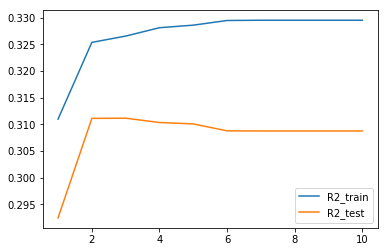

Try 8.


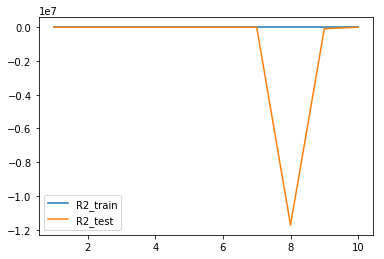

Try 9.


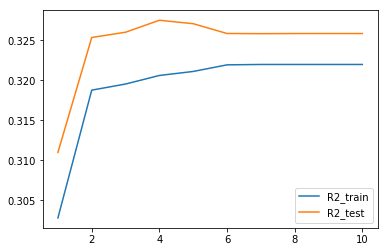

Try 10.


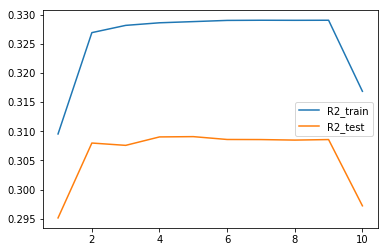

In [209]:
# Run multiple tries on different train/test sets to find the best polynomial degree
for i in range(1,11):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    degrees = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    R2_train_set = []
    R2_test_set = []
    print(f'Try {i}.')
    for degree in degrees:
        reg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        reg = reg.fit(X_train, y_train)
        R2_train = reg.score(X_train, y_train)
        R2_train_set.append(R2_train)
        R2_test = reg.score(X_test, y_test)
        R2_test_set.append(R2_test)

    # Plot to find the best degree
    plt.plot(degrees, R2_train_set, label = "R2_train")
    plt.plot(degrees, R2_test_set, label = "R2_test")
    plt.legend()
    plt.show()

From the chart, we can see that degree = 6 is where we get both highest R2 on test set and a high enough R2 on train set.

Now that we have the polynomial degree, we will perform GridSearchCV with KFold cross validation to improve the model.

In [205]:
from sklearn.model_selection import KFold
# Split train/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=420)
# Define model
model = LinearRegression()
poly = PolynomialFeatures(degree=6, include_bias=False)
poly_features = poly.fit_transform(X_train)
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
# Define parameters for tuning
parameters = {
        'fit_intercept': (True, False),
        'copy_X': (True, False),
        'n_jobs': (None, 5, 10),
        #'positive': (True, False)
        }
...
# Perform GridSearchCV using the default score of R2
search = GridSearchCV(model, parameters, cv=folds, return_train_score=True)
search.fit(poly_features,y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
       error_score='raise',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'fit_intercept': (True, False), 'copy_X': (True, False), 'n_jobs': (None, 5, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [206]:
import sklearn
y_pred = search.predict(poly.fit_transform(X_test))
R2_test = sklearn.metrics.r2_score(y_test, y_pred)
print(f'The final R2 score on test data is {R2_test}')

The final R2 score on test data is 0.322076246227998


# Conclusion

The relationship between security and spending, as well as between security and offer responsiveness has been proved. We eliminate the possibility that the high security group simply don't care about offers or don't have much interest in the brand because their offer view rate, though different, but was even higher than the other group (0.81 and 0.75). They cared, or at least was curious about the offers but it was not attractive enough for them to complete.<br>
The most reasonable explanation here is that because of lacking demographic information, the offer strategies were not personalized enough for those people. To solve this, either Starbucks can think of other offer program and test until they have a good response on those people, or they can find a way to collect more information from them.<br>
On a positive side, we can say that the offer personalizing strategy is working well because the people who provided personal information are very responsive with high completed rate and high spending volume. A R2 square on regression model of 0.33 implies that there are still room to improve and if we can get more personal information from all of our customers, we will be able to personalize the offer strategy better.<br>

## Limitation

There is one problem with the completed offers that hasn't been tackled in this solution is that: a person may accidently complete an offer without seeing/knowing it. To evaluate the responsiveness more precisely, we can eliminate the accidently completed offers by filtering only offer completed within offering time (from received until expired) and after it was viewed.<br>
However, given the very high rate of viewed offer, we can say that performing further cleaning will not likely change the result of this analysis.<br>
Another limitation of this research is that there are some valuable data that has not been utilized, for example: demographic information, offer channels. We can do many things with those data, such as: using regression to predict transaction amount and offer responsiveness, perform classification to find the most suitable offer to each customer group. Those are not in the focus of this solution but can be good suggestions for further analysis. 

# End.